# SUMMARY OF FILE

In this file I have tried to see if it is possible to predict a drinks rating given different information web scraped from the BCL website. 
The business question is to see which products receive the highest ratings which will inform how the inventory should be managed for the next year to improve the overall rating of drinks available. Higher rating -> greater customer satisfaction -> perhaps more footfall in store. 

## What did I do?
I started with attempting to predicting rating using all the types of drinks (i.e. wine, beer, spirits etc.).
I quickly found that the column categories are poorly labelled/designed. 
- _source.subCategory.description : is meant to be an overview category (i.e. tequila, beer, whiskey) but for some reason sub categorises wine into categories based on country but does not do the same for other drinks
- _source.style : only sub-categorises beer styles
- _source.redVarietal : (not included) but only sub-categorises the red wines


- I wanted to use teh drink category as an independent varibale, however, since there were too many wine categories I decided to cluster the wines from 21 types into a smaller amount. 


- Since I did not know how many clusters I should set, I plotted a `dendogram` using `ward` method to minimizes variance within clusters. I then decided to set 5 clusters and used `AgglomerativeClustering` algorithm to categorise the wines.


- I then used `PCA` to try and visualise the 5 clusters although I did not gain much insight from this plot. 

- I then used the 'price', 'alcohol percentage' and 'drink type' as independent variables in my model. Using `one-hot encoding` to split the 'drink type' into dummy variables.

- My dependent variable (the one I was trying to predict) was the drink rating. 

- I then split the data into `test and train`. 

- And `scaled the data`.

#### I then tried 4 regression approaches:
1. linear regression
2. random forest regression (`ensemble learning : bagging`)
3. gradient boosting (`ensemble learning : boosting`)
4. neural networks

- I also tried a `grid search` to tune `hyper parameters` to see if I could improve the random forest models outcome. 
- I used RMSE and R^2 to evaluate model performace, and they all performed poorly. 

Note to check if more data would be useful we could try a `learning curve`. 


#### Regression was not successful let's try classification:
I split the ratings into 3 catergories (so I could practice working with multi-class classification) 'good', 'average' and 'bad'.</br>
I then tried to predict the beer rating category using a classification model. 

I tried to use
1. random forest (`ensemble learning : bagging`)

I could also have tried KNN or SVC, however, I thought random forest is more robust to noise. 

Here is a comparison of KNN, SVC and random forest.

| Feature                       | K-Nearest Neighbors (KNN)                   | Support Vector Classifier (SVC)          | Random Forest                             |
|-------------------------------|---------------------------------------------|------------------------------------------|------------------------------------------|
| **Type**                      | Supervised                                  | Supervised                               | Supervised                               |
| **Algorithm**                 | Instance-based, lazy learning               | Decision boundary-based                   | Ensemble method using decision trees     |
| **Data Requirement**          | Requires labeled data                       | Requires labeled data                    | Requires labeled data                    |
| **Training Phase**            | No explicit training; stores instances      | Learns the optimal hyperplane            | Trains multiple decision trees           |
| **Prediction Phase**          | Computes distances to neighbors             | Predicts based on support vectors        | Majority voting from decision trees      |
| **Complexity**                | O(n) for each prediction (n: number of instances) | O(n^2) or O(n^3) (depends on kernel)  | O(log(n) * t) (t: number of trees)     |
| **Scalability**               | Poor with large datasets (slow prediction) | Can be slow for large datasets           | Scales well with large datasets          |
| **Interpretability**          | Easy to interpret                           | Less interpretable (complex decision boundary) | Moderate interpretability (feature importance) |
| **Handling Non-linearity**    | Can handle non-linear decision boundaries (using distance metric) | Good (especially with RBF kernel) | Can capture complex relationships        |
| **Handling Noise**            | Sensitive to noisy data                     | Can handle noise with proper regularization | Robust to noise                          |
| **Overfitting**               | Prone to overfitting with low k            | Can overfit if not properly tuned       | Less prone due to ensemble approach      |
| **Advantages**                | Simple to implement, no training phase      | Effective for high-dimensional spaces    | Robust, handles various data types       |
| **Disadvantages**             | Computationally expensive at prediction time | Sensitive to outliers, requires tuning   | Can be less interpretable than single tree models |


Then for the random forest model I checked model performance by looking at the:
- Confusion matrix
- Classification report
- ROC curve
- Learning curve


---
---

# OUTCOME

1. More data would help, but it would not improve the model to an acceptable accuracy.
2. Go back to EDA:
    - remove beers with few representative labels
    - try dimensionality reduction 
    - be more careful about outlier detection
3. More feature engineering could help:
    - calculate ABV (alcohol content by volume)
    - calculate ABV/$ (alcohol content by volume by dollar)
    - check if a drink is on promotion
    - use LLM to categorise beer tasting profiles
    - break up the certifications
    - use image analysis to rank branding 
    - use well know 'beer trees' to cluster beers without using ML
4. Imrpoving the models
    - Resampling Techniques: Use oversampling (e.g., SMOTE) for lower-rated classes or undersampling for higher-rated classes.
    - Cost-sensitive Learning: Assign different weights to classes when training the model to penalize the model more for misclassifying the minority classes.


---
---


In [232]:
import csv
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', 70)

import plotly.io as pio
pio.renderers.default = "vscode"


# Load .csv into dataframe

In [5]:
df = pd.read_csv('data/for-analysis.csv',
                delimiter=',',            # Comma as delimiter
                quotechar='"',            # Use double quotes for quoting
                quoting=csv.QUOTE_MINIMAL,  # Minimal quoting (or csv.QUOTE_ALL as needed)
                doublequote=True, 
                encoding='utf-8',
                )

df.describe(include='all')

,_source.consumerRating,_score,_source.votes,_source.regularPrice,_source.tastingDescription,_source.availableUnits,_source.certificates,_source.name,_source.style,_source.subCategory.description,_source.alcoholPercentage,_source.sweetness,_source.countryName,lat,lon,country_code02,country_code03
count,5548.000000,5548.000000,5548.000000,5548.000000,5548,5548.000000,5548,5548,460,5548,5548.000000,2898.000000,5548,5548.000000,5548.000000,5548,5548
unique,NaN,NaN,NaN,NaN,4684,NaN,7,5068,26,39,NaN,NaN,65,NaN,NaN,65,65
top,NaN,NaN,NaN,NaN,False,NaN,[],FIREBALL,Lager,France Wine,NaN,NaN,France,NaN,NaN,FR,FRA
freq,NaN,NaN,NaN,NaN,278,NaN,5093,7,157,1277,NaN,NaN,1387,NaN,NaN,1387,1387
mean,3.593980,0.498403,75.382300,216.672383,NaN,1454.248198,NaN,NaN,NaN,NaN,18.977648,0.700138,NaN,39.766035,-26.482100,NaN,NaN
std,1.271495,0.136803,103.675391,1549.303348,NaN,2966.984517,NaN,NaN,NaN,NaN,13.192768,2.081728,NaN,26.440664,70.864044,NaN,NaN
min,0.000000,0.200588,0.000000,1.990000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,-41.500083,-107.991707,NaN,NaN
25%,3.400000,0.362997,7.000000,19.990000,NaN,67.000000,NaN,NaN,NaN,NaN,12.500000,0.000000,NaN,39.783730,-100.445882,NaN,NaN
50%,3.900000,0.595873,41.000000,35.490000,NaN,574.000000,NaN,NaN,NaN,NaN,13.500000,0.000000,NaN,46.603354,-3.276575,NaN,NaN
75%,4.300000,0.601447,107.000000,87.990000,NaN,1768.250000,NaN,NaN,NaN,NaN,17.000000,0.000000,NaN,54.702354,1.888334,NaN,NaN


# Removing rows where rating, price, alcohol percentage, country_code03 is nan

In [46]:
df.columns

Index(['_source.consumerRating', '_score', '_source.votes',
       '_source.regularPrice', '_source.tastingDescription',
       '_source.availableUnits', '_source.certificates', '_source.name',
       '_source.style', '_source.subCategory.description',
       '_source.alcoholPercentage', '_source.sweetness', '_source.countryName',
       'lat', 'lon', 'country_code02', 'country_code03', 'drink_category'],
      dtype='object')

In [8]:
drop_nan_from_col = ['_source.consumerRating', 
                     '_source.regularPrice', 
                     '_source.alcoholPercentage',
                     'country_code03']

df = df.dropna(subset = drop_nan_from_col)
df.describe(include='all')


,_source.consumerRating,_score,_source.votes,_source.regularPrice,_source.tastingDescription,_source.availableUnits,_source.certificates,_source.name,_source.style,_source.subCategory.description,_source.alcoholPercentage,_source.sweetness,_source.countryName,lat,lon,country_code02,country_code03
count,5548.000000,5548.000000,5548.000000,5548.000000,5548,5548.000000,5548,5548,460,5548,5548.000000,2898.000000,5548,5548.000000,5548.000000,5548,5548
unique,NaN,NaN,NaN,NaN,4684,NaN,7,5068,26,39,NaN,NaN,65,NaN,NaN,65,65
top,NaN,NaN,NaN,NaN,False,NaN,[],FIREBALL,Lager,France Wine,NaN,NaN,France,NaN,NaN,FR,FRA
freq,NaN,NaN,NaN,NaN,278,NaN,5093,7,157,1277,NaN,NaN,1387,NaN,NaN,1387,1387
mean,3.593980,0.498403,75.382300,216.672383,NaN,1454.248198,NaN,NaN,NaN,NaN,18.977648,0.700138,NaN,39.766035,-26.482100,NaN,NaN
std,1.271495,0.136803,103.675391,1549.303348,NaN,2966.984517,NaN,NaN,NaN,NaN,13.192768,2.081728,NaN,26.440664,70.864044,NaN,NaN
min,0.000000,0.200588,0.000000,1.990000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,-41.500083,-107.991707,NaN,NaN
25%,3.400000,0.362997,7.000000,19.990000,NaN,67.000000,NaN,NaN,NaN,NaN,12.500000,0.000000,NaN,39.783730,-100.445882,NaN,NaN
50%,3.900000,0.595873,41.000000,35.490000,NaN,574.000000,NaN,NaN,NaN,NaN,13.500000,0.000000,NaN,46.603354,-3.276575,NaN,NaN
75%,4.300000,0.601447,107.000000,87.990000,NaN,1768.250000,NaN,NaN,NaN,NaN,17.000000,0.000000,NaN,54.702354,1.888334,NaN,NaN


In [14]:
print(f"Types of beer '_source.style' = {df['_source.style'].unique()}")
print(f"Types of drink '_source.subCategory.description' = {df['_source.subCategory.description'].unique()}")

Types of beer '_source.style' = [nan 'California Common Or Steam' 'India Pale Ale' 'Pale Ale' 'Wheat'
 'Pilsner' 'Lager' 'Dark Lager' 'Other' 'Brown Ale' 'Variety Pack'
 'Strong Ale' 'Porter' 'Stout' 'Belgian Ale' 'Blonde Ale' 'Sour'
 'Gluten-free' 'Bock' 'Amber Ale' 'Cream Ale' 'Altbier' 'Red Ale'
 'Fruit Ale' 'Scotch Ale' 'Bitter' 'Radler']
Types of beer '_source.subCategory.description' = ['Italy Wine' 'France Wine' 'Spain Wine' 'Portugal Wine' 'Fortified Wine'
 'Greece Wine' 'Argentina Wine' 'USA Wine' 'Sake' 'Australia Wine'
 'Canada - Other' 'Canada - BC' 'Other Country Wine' 'Germany Wine'
 'South Africa Wine' 'De-Alcoholized Product' 'Austria Wine' 'Chile Wine'
 'China Wine' 'Israel Wine' 'New Zealand Wine' 'Other Style Wine'
 'Hungary Wine' 'Georgia Wine' 'Bulgaria Wine' 'Domestic - BC Beer'
 'Domestic - Other Province Beer' 'Import Beer' 'Asian Spirits' 'Whisky'
 'Tequila' 'Liqueurs' 'Other Spirits' 'Grape and Fruit Brandy' 'Vodka'
 'Rum' 'Gin' 'Coolers' 'Cider']


## Use clustering to reduce the number of wine types. 

There are soo many wine categories that I will need to reduce the number of categories. 

One 'easy' and obvious way is to cluster based on geographic location. However, wine can be so diverse that this may not be an optimal way of clustering wine. 
But I do not know how many cluster the wine is in so I will use **Hierarchical Clustering** which will 'work out' how many cluster to partition the data into. 
There are two types of **Hierarchical Clustering**:
1. Agglomerative Clustering (Bottom-up): Starts with each data point as its own cluster and merges them step-by-step.
2. Divisive Clustering (Top-down): Starts with one cluster containing all points and recursively splits them.

scikit-learn uses Agglomerative Clustering so I will be using that. 


In [233]:
df_wine = df[df['_source.subCategory.description'].str.contains('wine', case=False, na=False)]

print(f"Types of drink '_source.subCategory.description' = {df_wine['_source.subCategory.description'].unique()}")

print(f"No. types of drink '_source.subCategory.description' = {len(df_wine['_source.subCategory.description'].unique())}")

Types of drink '_source.subCategory.description' = ['Italy Wine' 'France Wine' 'Spain Wine' 'Portugal Wine' 'Fortified Wine'
 'Greece Wine' 'Argentina Wine' 'USA Wine' 'Australia Wine'
 'Other Country Wine' 'Germany Wine' 'South Africa Wine' 'Austria Wine'
 'Chile Wine' 'China Wine' 'Israel Wine' 'New Zealand Wine'
 'Other Style Wine' 'Hungary Wine' 'Georgia Wine' 'Bulgaria Wine']
No. types of drink '_source.subCategory.description' = 21


In [16]:
# conda install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch


# Select the features for clustering
features = ['_source.regularPrice', '_source.alcoholPercentage', '_score', '_source.votes']

# ['_source.consumerRating', '_score', '_source.votes',
#        '_source.regularPrice', '_source.tastingDescription',
#        '_source.availableUnits', '_source.certificates', '_source.name',
#        '_source.style', '_source.subCategory.description',
#        '_source.alcoholPercentage', '_source.sweetness', '_source.countryName',
#        'lat', 'lon', 'country_code02', 'country_code03'],

# Handle missing values and scale the features
df_features = df_wine[features].fillna(0)  # You can adjust the NaN handling strategy here
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)


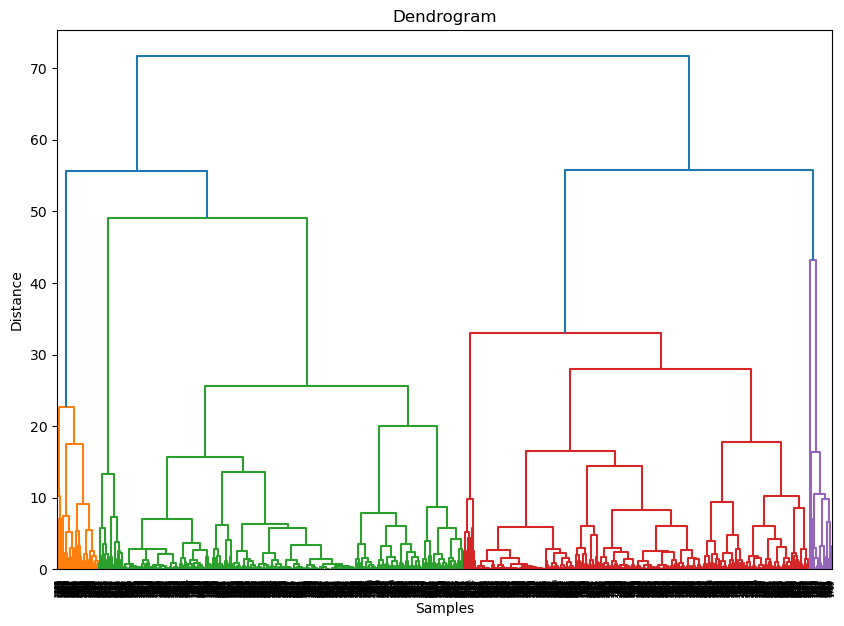

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical/agglomerative clustering
linked = linkage(scaled_features, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


In [41]:
# Picking 6 clusters from the dendrogram 
n_clusters = 5

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
clusters = agg_cluster.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
df_wine.loc[:, 'cluster'] = clusters.squeeze()

# Display the cluster assignments
print(df_wine['cluster'].value_counts())
print(df_wine['_source.subCategory.description'].value_counts())

cluster
2    1332
1    1311
3     162
4      90
0      85
Name: count, dtype: int64
_source.subCategory.description
France Wine           1277
Italy Wine             455
USA Wine               298
Australia Wine         188
Chile Wine             149
Spain Wine             112
Fortified Wine         100
New Zealand Wine        91
Argentina Wine          86
South Africa Wine       51
Germany Wine            50
Portugal Wine           45
Other Country Wine      29
Hungary Wine            10
Greece Wine              8
Other Style Wine         8
Israel Wine              7
Austria Wine             6
China Wine               6
Georgia Wine             3
Bulgaria Wine            1
Name: count, dtype: int64


In [33]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)

plot_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
plot_data['cluster'] = df_wine['cluster']


# Create an interactive scatter plot with Plotly
fig = px.scatter(
    plot_data, 
    x='PC1', 
    y='PC2', 
    color='cluster', 
    title='Agglomerative Clustering with 5 Clusters',
    color_continuous_scale=px.colors.qualitative.Set1,
    labels={'cluster': 'Cluster'},
    hover_name=plot_data.index  # Optional: Display index on hover
)


fig.update_layout(width=800,
                 height=600, )

# Show the plot
fig.show()



## Using wine clusters to re-categorise the main df

In [53]:
df.loc[:,'drink_category'] = df['_source.subCategory.description']

# Update drink_category for rows in wine_df based on their index
for index in df_wine.index:
    df.loc[index, 'drink_category'] = f'wine_{df_wine.loc[index, "cluster"]}'

In [66]:
# Display the updated DataFrame
print(df['drink_category'].value_counts())

drink_category
wine_2                            1332
wine_1                            1311
Whisky                             601
Canada - BC                        475
Domestic - BC Beer                 287
Liqueurs                           178
wine_3                             162
Vodka                              146
Coolers                            126
Rum                                124
Import Beer                        115
Tequila                             97
wine_4                              90
wine_0                              85
Gin                                 81
Grape and Fruit Brandy              75
Domestic - Other Province Beer      60
Sake                                56
Asian Spirits                       54
Cider                               32
Other Spirits                       29
De-Alcoholized Product              20
Canada - Other                      12
Name: count, dtype: int64


## Let's split our categorical data using one hot encoding

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'RATING' is your target variable and you've already created 'drink_category'
# Selecting features
features = ['_source.regularPrice', '_source.alcoholPercentage']
X = df[features]
y = df['_source.consumerRating']

# ['_source.consumerRating', '_score', '_source.votes',
#        '_source.regularPrice', '_source.tastingDescription',
#        '_source.availableUnits', '_source.certificates', '_source.name',
#        '_source.style', '_source.subCategory.description',
#        '_source.alcoholPercentage', '_source.sweetness', '_source.countryName',
#        'lat', 'lon', 'country_code02', 'country_code03'],

# Convert categorical variable 'drink_category' to numerical values using one-hot encoding
# X = pd.get_dummies(X, columns=['drink_category'], drop_first=True)

# Handling missing values (if any)
X.fillna(0, inplace=True)


/var/folders/17/p8qnv7p57d73kx2f_7bd35bm0000gn/T/ipykernel_73616/222879085.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Split data into test/train

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scale the features

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL : Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluation
mse_linear = root_mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression - MSE: {mse_linear}, R²: {r2_linear}')


Linear Regression - MSE: 1.236309515919036, R²: 0.0057393177091874525


# MODEL : Random Forest Regression

In [72]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
mse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Regression - MSE: {mse_rf}, R²: {r2_rf}')


Random Forest Regression - MSE: 1.2452288788704904, R²: -0.008658632837474478


# MODEL : Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluation
mse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting Regression - MSE: {mse_gb}, R²: {r2_gb}')


Gradient Boosting Regression - MSE: 1.1757196012798312, R²: 0.1008060855059999


# MODEL : Neural Networks

In [74]:
from sklearn.neural_network import MLPRegressor

# Train the model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluation
mse_nn = root_mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Neural Network Regression - MSE: {mse_nn}, R²: {r2_nn}')


Neural Network Regression - MSE: 1.1879966068130592, R²: 0.08192905722758348


# OPTIMISATION with Grid Search

In [75]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best model
best_rf_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Applications/anaconda3/envs/2deg_yodels_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
143 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/2deg_yodels_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/2deg_yodels_env/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Applications/anaconda3/envs/2deg_yodels_env/lib/python3.10/site-packages/sklearn

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [76]:
# Predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# Evaluation
mse_best_rf = root_mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print(f'Optimized Random Forest Regression - MSE: {mse_best_rf}, R²: {r2_best_rf}')


Optimized Random Forest Regression - MSE: 1.1551004943721046, R²: 0.13206863885426523


In [89]:
df_beer = df[df['_source.subCategory.description'].str.contains('beer', case=False, na=False)]


In [92]:
def create_box_plot(df, category_col, target_col):
    median_values = df.groupby(category_col)[target_col].median().sort_values(ascending=False)
    
    # Create the box plot with ordered categories
    fig = px.box(df, 
                 x=category_col, 
                 y=target_col, 
                 category_orders={category_col: median_values.index},  # Order x-axis by median values
                 title=f'Box Plot of {target_col} by {category_col}')
    
    fig.update_traces(marker=dict(size=4))  # Adjust marker size if needed
    fig.update_layout(width=800,
                 height=600, )
    fig.show()

# Call the function for each categorical variable
create_box_plot(df_beer, '_source.certificates', '_source.consumerRating')
create_box_plot(df_beer, '_source.style', '_source.consumerRating')
create_box_plot(df_beer, '_source.countryName', '_source.consumerRating')
create_box_plot(df_beer, 'drink_category', '_source.consumerRating')

## Let's work with just the beer to see if we can predict the rating

But let's categorise the countries and types of beer similar to the wine types as we have too many categories with not enough data poiunts per category.

Starting with beer type.

I want to use the beer flavouring to categories the beers, to do that I will use NLP to look for specific wording in the beer descriptions and provide marking based on the description. Then I will use these characteristics to cluster the beers. 

## Tried using TfidfVectorizer (wrong approach)

I realised this is a wrong approach after the fact. The feature score is really just a sum of how many times the word appears in the dscription. So a high score on bitterness is just saying that many of the values under the key 'bitterness' are in the description. So we don't have an idea of bittereness. I.e. 'very bitter' will be the same as 'not very bitter'. 
But I want to keep this code here as it was an interesting exercise. 

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample beer descriptions (replace with your actual data)
descriptions = df_beer['_source.tastingDescription'].tolist()


features_keywords = {
    'aroma': ['floral', 'fruity', 'aroma', 'scent', 'pine', 'spice', 'herb', 'citrus', 'caramel', 'malt', 'toasty', 'chocolate', 'coffee', 'tropical', 'juicy', 'rich', 'nutty', 'sweet', 'heather', 'lemon', 'orange', 'grapefruit', 'peach'],
    'bitterness': ['bitter', 'bitterness', 'hoppy', 'hop', 'pine', 'spice', 'earthiness', 'herbaceous', 'tart', 'smooth', 'dry', 'crisp', 'refreshing'],
    'flavour': ['sweet', 'spice', 'malty', 'citrus', 'hop', 'caramel', 'fruit', 'chocolate', 'coffee', 'nutty', 'liquorice', 'bready', 'toasty', 'cereal', 'refreshing', 'bold', 'complex', 'roasted', 'sour', 'full-bodied', 'light', 'creamy', 'juicy'],
    'body': ['smooth', 'light', 'medium', 'full-bodied', 'creamy', 'velvety', 'rich', 'heavy', 'silky', 'easy-drinking', 'pillowy', 'thick', 'clean'],
    'clarity': ['crisp', 'clear', 'hazy', 'cloudy', 'unfiltered', 'pale', 'dark', 'golden'],
}



# Vectorize the beer descriptions using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(descriptions)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate feature scores based on keywords
def calculate_feature_score(description, feature_keywords):
    score = sum([description.count(keyword) for keyword in feature_keywords])
    return score

# Create a DataFrame to store feature scores
feature_scores = pd.DataFrame()
for feature, keywords in features_keywords.items():
    feature_scores[feature] = [calculate_feature_score(desc, keywords) for desc in descriptions]



df_beer.loc[:, ['aroma', 'bitterness', 'flavour', 'body', 'clarity']] = feature_scores[['aroma', 'bitterness', 'flavour', 'body', 'clarity']].values



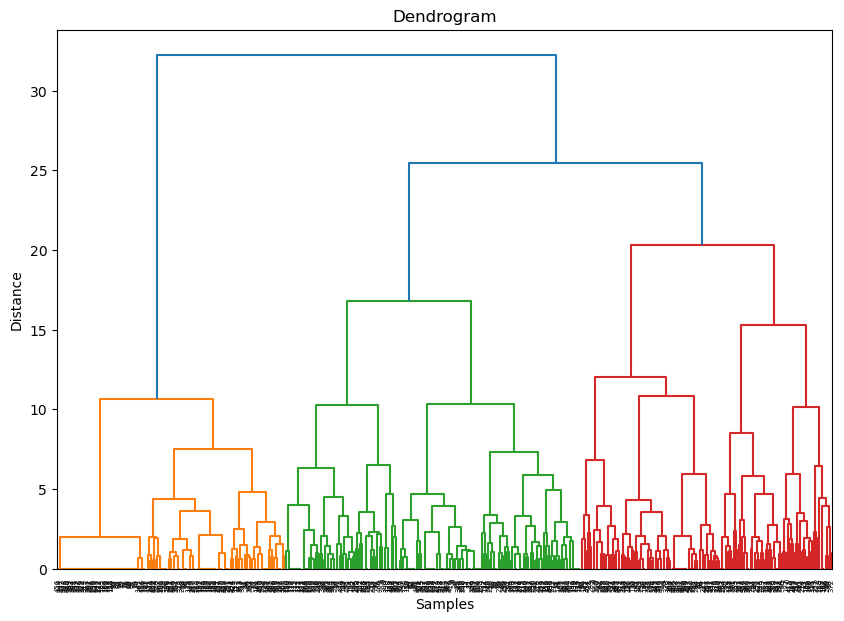

In [204]:
# Select the features for clustering
features = ['aroma', 'bitterness', 'flavour', 'body', 'clarity']

# Handle missing values and scale the features
df_features = df_beer[features].fillna(0)  # You can adjust the NaN handling strategy here
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

# Perform hierarchical/agglomerative clustering
linked = linkage(scaled_features, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [205]:
# Picking 6 clusters from the dendrogram 
# n_cluster_list = [2, 3, 4, 5, 6, 7, 8]
n_cluster_list = [4]


for i, n_clusters in enumerate(n_cluster_list):
    # Apply Agglomerative Clustering
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = agg_cluster.fit_predict(scaled_features)

    # print(type(clusters))

    # Add cluster labels to the original DataFrame
    df_beer.loc[:, 'cluster'] = clusters

    # # Display the cluster assignments
    # print(df_wine['cluster'].value_counts())
    # print(df_wine['_source.subCategory.description'].value_counts())
    print('-'*80)
    print('-'*80)
    print(f'NUMBER OF CLUSTERS = {n_clusters}')

    create_box_plot(df_beer, '_source.style', 'cluster')

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
NUMBER OF CLUSTERS = 4


## METHOD 2 FOR TEXT CLUSTERING

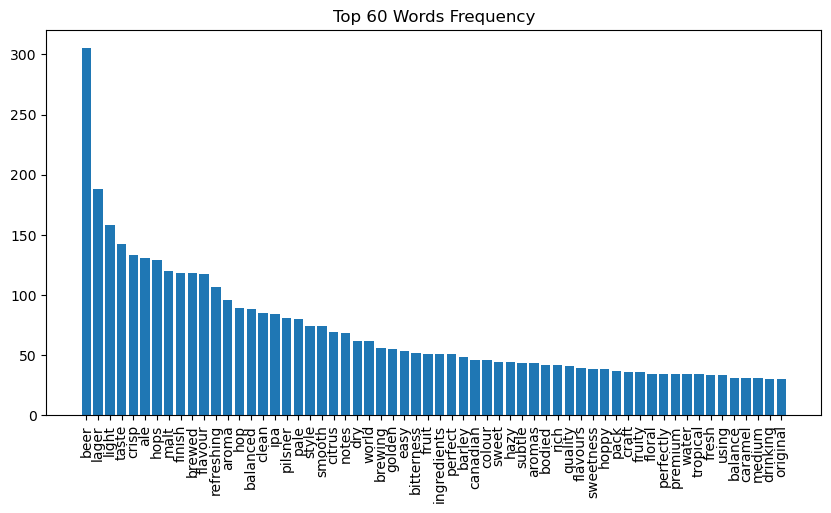

In [216]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df_beer['_source.tastingDescription'])

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Plot the top 30 most frequent words
words = [wf[0] for wf in word_freq[:60]]
counts = [wf[1] for wf in word_freq[:60]]

# create_box_plot(df_beer, '_source.style', 'cluster')

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 60 Words Frequency")
plt.show()


In [220]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df_beer.loc[:,'clean_text'] = df_beer['_source.tastingDescription'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johanndrayne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_beer['clean_text'])


In [235]:
from sklearn.cluster import KMeans

# Apply K-Means with a predetermined number of clusters
# num_clusters = 10
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(X_tfidf)

# # Get the cluster assignments
# labels_kmeans = kmeans.labels_
# df_beer.loc[:, 'cluster_kmeans'] = labels_kmeans


# Picking 6 clusters from the dendrogram 
n_cluster_list = [8, 10, 12, 14, 16, 18, 20]
n_cluster_list = [16]


for i, n_clusters in enumerate(n_cluster_list):
    # Apply Agglomerative Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_tfidf)

    # Get the cluster assignments
    labels_kmeans = kmeans.labels_
    df_beer.loc[:, 'cluster_kmeans'] = labels_kmeans    

    # # Display the cluster assignments
    print('-'*80)
    print('-'*80)
    print(f'NUMBER OF CLUSTERS = {n_clusters}')

    create_box_plot(df_beer, '_source.style', 'cluster_kmeans')

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
NUMBER OF CLUSTERS = 16


In [228]:
# Assuming 'RATING' is your target variable and you've already created 'drink_category'
# Selecting features

## USE CLUSTERED CATEGORIES
# features = ['_source.regularPrice', '_source.alcoholPercentage', 'cluster',]
# X = df_beer[features]
# y = df_beer['_source.consumerRating']

# # Convert categorical variable 'drink_category' to numerical values using one-hot encoding
# X = pd.get_dummies(X, columns=['cluster'], drop_first=True)

## USE NLP FEATURES DIRECTLY
# features = ['_source.regularPrice', '_source.alcoholPercentage', 'aroma', 'bitterness', 'flavour', 'body', 'clarity']
# X = df_beer[features]
# y = df_beer['_source.consumerRating']

## USE KMEANS and NLTK CLUSTERED CATEGORIES
features = ['_source.regularPrice', '_source.alcoholPercentage', 'cluster_kmeans',]
X = df_beer[features]
y = df_beer['_source.consumerRating']

# Convert categorical variable 'drink_category' to numerical values using one-hot encoding
X = pd.get_dummies(X, columns=['cluster_kmeans'], drop_first=True)



# Handling missing values (if any)
X.fillna(0, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [229]:
# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluation
mse_linear = root_mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression - MSE: {mse_linear}, R²: {r2_linear}')


Linear Regression - MSE: 0.5005723143034023, R²: 0.3806732949309425


In [230]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
mse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Regression - MSE: {mse_rf}, R²: {r2_rf}')


Random Forest Regression - MSE: 0.5439260330151884, R²: 0.26875005649491346


In [231]:
# Train the model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluation
mse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting Regression - MSE: {mse_gb}, R²: {r2_gb}')


Gradient Boosting Regression - MSE: 0.5149527707759178, R²: 0.3445780924306876


## Let's try classification instead...

Let's split the beer into 3 groups by rating. 
Bad, average and good. 

Let's split it by percentile and see if it makes sense. 

In [248]:
fig = px.histogram(df_beer['_source.consumerRating'], nbins=50)

lower_bound = df_beer['_source.consumerRating'].quantile(0.33)
upper_bound = df_beer['_source.consumerRating'].quantile(0.66)

fig.add_vline(x=lower_bound, line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x=upper_bound, line_width=2, line_dash="dash", line_color="red")


fig.show()


### How to choose the percentiles
We could use Z-Score/Standard Deviation Binning. To try and auto tackle the skew, but let's just go with a manual approach. 

In [256]:
# Function to categorize based on observed skewed distribution
def categorize_rating_skewed(rating):
    if rating < 3.5:
        return 'bad'
    elif 3.5 <= rating <= 4.2:
        return 'average'
    else:
        return 'good'

# Apply the skew-adjusted categorization
df_beer.loc[:,'rating_category'] = df_beer['_source.consumerRating'].apply(categorize_rating_skewed)

px.bar(df_beer['rating_category'])

### Now for the classification model

I will need to label the beer styles. There are two methods:
1. Label Encoding:
- Use it if your categorical feature has a meaningful order (e.g., ordinal data).
- Use it when you're working with models that don't assume a linear relationship between categories, such as tree-based models (e.g., Random Forest, Decision Trees, Gradient Boosting). These models are less affected by the numeric encoding of categories.
2. One-Hot Encoding:
- Use it if your categorical feature is nominal (no inherent order between categories).
- Use it when working with models like linear regression or logistic regression, which can be sensitive to the numeric ordering of categories introduced by label encoding.

In [264]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## USE KMEANS and NLTK CLUSTERED CATEGORIES
features = ['_source.regularPrice', '_source.alcoholPercentage', 'cluster_kmeans',]
X = df_beer[features]
y = df_beer['rating_category']

# Convert categorical variable 'drink_category' to numerical values using one-hot encoding
X = pd.get_dummies(X, columns=['cluster_kmeans'], drop_first=True)


# Handling missing values (if any)
X.fillna(0, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)


In [265]:
# Model score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.54


In [274]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# fig = px.density_heatmap(conf_matrix, text_auto=True,  # Automatically add text annotations
#                  color_continuous_scale='Blues')
labels = clf.classes_

fig = px.imshow(conf_matrix, 
                 labels=dict(x="Predicted", y="Actual", color="Count"),
                 x=labels,
                 y=labels,
                 text_auto=True,  # Automatically add text annotations
                 color_continuous_scale='Blues')

fig.update_layout(xaxis_title="Predicted", 
                  yaxis_title="Actual",
                  width=800,
                 height=600, )


fig.show()



Confusion Matrix:
[[45 15 17]
 [15 20  4]
 [ 7  6 10]]


### Classification report

- Precision:
Definition: The ratio of correctly predicted positive observations to the total predicted positives. </br>
Meaning: High precision means that when the model predicts a class, it’s often correct.

- Recall (also known as Sensitivity or True Positive Rate):
Definition: The ratio of correctly predicted positive observations to the all observations in the actual class.
Meaning: High recall means that the model correctly identifies most instances of the class.

- F1-Score:
Definition: The harmonic mean of precision and recall.

- Support:
Definition: The number of actual occurrences of each class in the test dataset. This shows how many instances of each class were evaluated.

- Accuracy:
Definition: The ratio of correct predictions (true positives + true negatives) to the total predictions.
Definition: Accuracy can be misleading if the dataset is imbalanced, which is why other metrics like precision, recall, and F1-score are important to consider.


In [267]:
# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

     average       0.67      0.58      0.62        77
         bad       0.49      0.51      0.50        39
        good       0.32      0.43      0.37        23

    accuracy                           0.54       139
   macro avg       0.49      0.51      0.50       139
weighted avg       0.56      0.54      0.55       139



The overall accuracy is 54%, indicating moderate performance. The relatively low F1-score for the "good" class suggests the model may need more data or further tuning to handle this category better.

### Looking at ROC curve

 ROC (Receiver Operating Characteristic) helps evaluate the trade-off between the true positive rate (TPR) and the false positive rate (FPR) for a range of threshold values.
- True Positive Rate (TPR): Also known as sensitivity or recall, it is the ratio of correctly predicted positive observations to all actual positives. It indicates how well the model identifies positive instances.
- False Positive Rate (FPR): It is the ratio of incorrectly predicted positive observations to all actual negatives. It shows the proportion of negative instances that are incorrectly classified as positive.

#### Reading a ROC a curve
- The X-axis represents the False Positive Rate (FPR).
- The Y-axis represents the True Positive Rate (TPR).
- The diagonal line (from (0,0) to (1,1)) represents a model that makes random predictions. The further the ROC curve is from this diagonal, the better the model's performance.

- BOTTOM LEFT (Threshold = High):
    - TPR = 0: No true positive predictions.
    - FPR = 0: No false positive predictions.
    - Implication: The model is very conservative; it only classifies a few samples as positive.
- TOP RIGHT (Threshold = Low):
    - TPR = 1: All actual positives are captured.
    - FPR = 1: All actual negatives are incorrectly classified as positives.
    - Implication: While this maximizes the true positives, the model becomes useless for practical applications, as it fails to identify any negatives.

#### Area under the Curve (AUC)
The Area Under the ROC Curve (AUC) quantifies the overall ability of the model to discriminate between positive and negative classes
- AUC = 1: Perfect model (all positives are classified as positive, and all negatives as negative).
- AUC = 0.5: No discrimination (the model is no better than random guessing).
- AUC < 0.5: The model performs worse than random guessing.


#### Using ROC curve
- Binary Classification Problems: ROC curves are primarily used for binary classification tasks, but can also be extended to multi-class problems by treating them as multiple binary classifications.
- Imbalanced Datasets: When you have a class imbalance (e.g., many more negatives than positives), ROC curves and AUC are more informative than accuracy. They focus on the model's performance in distinguishing between classes rather than just overall correctness.
- Threshold Selection: ROC curves help you choose the optimal threshold for your classifier based on the desired balance between TPR and FPR. This is particularly useful when the cost of false positives and false negatives is different.
- Comparing Models: You can use ROC curves to compare the performance of different models. A model with a higher AUC is generally preferred.

#### Multi-class approach
**One-vs-Rest (OvR) Approach**

This is the most common method for handling multi-class problems with ROC analysis:

For each class, you treat it as the positive class while treating all other classes as the negative class. This way, you create a binary classification problem for each class.</br>
Each class will have its own ROC curve, and you can calculate the AUC for each curve to understand the model's performance for that specific class.

In [287]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities on the test set
y_score = clf.predict_proba(X_test_scaled)

# Binarize the output labels
classes = clf.classes_  # Get the order of classes
y_bin = label_binarize(y_test, classes=classes)
n_classes = y_bin.shape[1]

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
# Create a Plotly figure
fig = go.Figure()

# Add ROC curves for each class to the figure
for i in range(n_classes):
    fig.add_trace(go.Scatter(
        x=fpr[i],
        y=tpr[i],
        mode='lines',
        name=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:.2f})',
        line=dict(width=2)
    ))

# Add random guessing line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Guessing (AUC = 0.5)',
    line=dict(dash='dash', color='black'),
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0.0, 1.0]),
    yaxis=dict(range=[0.0, 1.05]),
    showlegend=True,
    width=1000,
    height=600
)

# Show the plot
fig.show()


In [290]:
from sklearn.model_selection import learning_curve


# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)


# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train_scaled, y_train, 
                                                          train_sizes=np.linspace(0.1, 1.0, 10),
                                                          cv=5, n_jobs=-1)

# Calculate the mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



In [305]:

# Create a Plotly figure
fig = go.Figure()

# Add training score trace
fig.add_trace(go.Scatter(
    x=train_sizes,
    y=train_mean,
    mode='lines+markers',
    name='Training Score',
    line=dict(color='blue'),
    marker=dict(size=8)
))

# Add test score trace
fig.add_trace(go.Scatter(
    x=train_sizes,
    y=test_mean,
    mode='lines+markers',
    name='Test Score',
    line=dict(color='orange'),
    marker=dict(size=8)
))

# Add shaded area for standard deviation
fig.add_trace(go.Scatter(
    x=np.concatenate([train_sizes, train_sizes[::-1]]),
    y=np.concatenate([train_mean - train_std, (train_mean + train_std)[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Training Std Dev',
    showlegend=False
))


fig.add_trace(go.Scatter(
    x=np.concatenate([train_sizes, train_sizes[::-1]]),
    y=np.concatenate([test_mean + test_std, (test_mean - test_std)[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 127, 14, 0.2)',  # Example color for test area
    line=dict(color='rgba(255, 255, 255, 0)'),
    name='Test Std Dev',
    showlegend=False
))

# Update layout
fig.update_layout(
    title='Learning Curve',
    xaxis_title='Training Size',
    yaxis_title='Score',
    showlegend=True,
    width=1000,
    height=600
)

# Show the plot
fig.show()